In [1]:
# Library
import os
import sys
import numpy as np
from numpy import *
import pandas as pd

import math
from scipy import stats
import scipy.stats

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from random import *
import statistics as stat
from numpy.linalg import multi_dot
from numpy import linalg as LA

from statsmodels.graphics import tsaplots
from scipy.interpolate import make_interp_spline
from scipy import interpolate

#For Geopandas
import geopandas as gpd
import shapely.geometry
from shapely.geometry import Polygon
from shapely.geometry import Point

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import pylab as plt
import numpy.matlib
import scipy.integrate as integrate

from numpy.random import randn
from numpy.linalg import inv

#from function_compute_def import nucleus_u_cartesian
from rijksdriehoek import rijksdriehoek

plt.close('all')
plt.rcParams.update({'font.size': 18, 'legend.fontsize':18})

In [2]:
# import the outline of the gas field
RD = rijksdriehoek.Rijksdriehoek()

# import the boundary of the gas field
poly_field=np.loadtxt(fname="input_files/PetrelFieldPoly.dat", usecols=(0,1))
x_field, y_field = zip(*poly_field)
# convert in km    
x_field_km = np.zeros(len(x_field))
y_field_km = np.zeros(len(y_field))
for i in range(len(x_field)):
    x_field_km[i] = x_field[i]*1e-3
    y_field_km[i] = y_field[i]*1e-3

In [3]:
### Import the station
#df_prec = pd.read_csv('data/stations_precipitation20152020.csv')
#df_eva = pd.read_csv('data/stations_evapotransp20152020.csv')
df_station = pd.read_csv('KNMI_data20152020/stations.csv')

In [4]:
### convert location in Rdx and Rdx
RD.from_wgs(df_station['lat'], df_station['lon'])
df_station['Rdx'] = RD.rd_x
df_station['Rdy'] = RD.rd_y

In [5]:
### Station Nieuwolda
nw_ID = 20
df_nw = df_station.iloc[nw_ID]

### Station Eelde
eelde_ID = 17
df_eelde = df_station.iloc[eelde_ID]

### Station Nieuw Beerta
nb_ID = 7
df_nb = df_station.iloc[nb_ID]


In [6]:
### Import data per parcels to select points with seasonal pattern
df_parcels = pd.read_csv('InSAR/insart88_per_parcels250m_buffer.csv')
dates = np.loadtxt('InSAR/insar_dates_t88.txt')
Ny = df_parcels.shape[0]
n_parcel = Ny

# Compute the linear interpolation to remove the long term subsidence
x_year = dates/365

# interpolation
slope = np.zeros(Ny)
intercept = np.zeros(Ny)
y_regr = np.zeros((Ny,len(x_year)))

# equivalent to the displacement velocity
for i in range(Ny):
    slope[i], intercept[i], r, p, std_err = stats.linregress(x_year, df_parcels.iloc[i,20:20+217].to_numpy(float32))        
    y_regr[i,:] = slope[i] * x_year + intercept[i]


## Reduce the dataset and keep observation points wich have a seasonal pattern

In [7]:
### detrended dataframe
df_parceldetr = df_parcels.iloc[:,20:20+217] - y_regr

In [8]:
# point 3: same signal
ts1 = df_parceldetr.iloc[3,20:20+217].to_numpy(float64)
ts2 = df_parceldetr.iloc[140,20:20+217].to_numpy(float64)
ts3 = df_parceldetr.iloc[182,20:20+217].to_numpy(float64)
timeserie = df_parceldetr.iloc[140,20:20+217].to_numpy(float64)

test_corr = scipy.stats.pearsonr(ts1, timeserie)
print(test_corr)

## --> high pearson coefficient and small (<0.3) p-value to be considered closed enough

(0.08019789469324436, 0.2625973222747182)


In [9]:
### Select point in the data frame with a seasonal pattern
parcelts = [] #pd.DataFrame()
id_val = []
lat = []
lon = []
for i in range(n_parcel):
    timeserie = df_parceldetr.iloc[i,20:20+217].to_numpy(float64)
    test_corr1 = scipy.stats.pearsonr(ts1, timeserie)
    test_corr2 =  scipy.stats.pearsonr(ts2, timeserie)
    test_corr3 =  scipy.stats.pearsonr(ts3, timeserie)
    
    # 0.08
    if test_corr1[0]>0.1 and test_corr1[1]<0.25 and test_corr2[0]>0.1 and test_corr2[1]<0.25 and test_corr3[0]>0.1 and test_corr3[1]<0.25:
        id_val = np.append(id_val, i)
        lat = np.append(lat, df_parcels.iloc[i,3])
        lon = np.append(lon, df_parcels.iloc[i,4])
        row = df_parcels.iloc[i,20:20+217].to_numpy(float32)
        parcelts = np.append(parcelts, [row], axis=None)

nrow = int(len(parcelts)/ 217)
parcelts = np.resize(parcelts, (nrow,217))
    
len(parcelts)

2072

In [10]:
df_reduce = pd.DataFrame()

### Create the data frame
df_reduce['ID'] = id_val

### convert location in Rdx and Rdx
RD.from_wgs(lat, lon)
df_reduce['Rdx'] = RD.rd_x
df_reduce['Rdy'] = RD.rd_y

df_reduce = pd.concat([df_reduce, pd.DataFrame(parcelts)], axis=1)

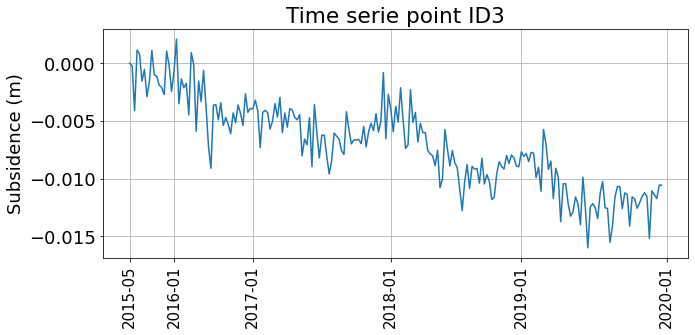

In [14]:
plt.close('all')
xaxis = [0, 18, 50, 106, 159, 218]
# year-month-day
xlabel = ['2015-05',
          '2016-01',
          '2017-01',
          '2018-01',
          '2019-01',
          '2020-01']

for i in range(1):
    plt.figure(figsize=(10,5))
    plt.plot(df_reduce.iloc[3, 3:],'-')
    plt.xticks(xaxis, labels=xlabel, rotation='vertical',fontsize=15)
    plt.ylabel('Subsidence (m)')
    plt.title('Time serie point ID3')
    plt.tight_layout()
    plt.grid(True)

## Visualize the observation points with the meteorological stations

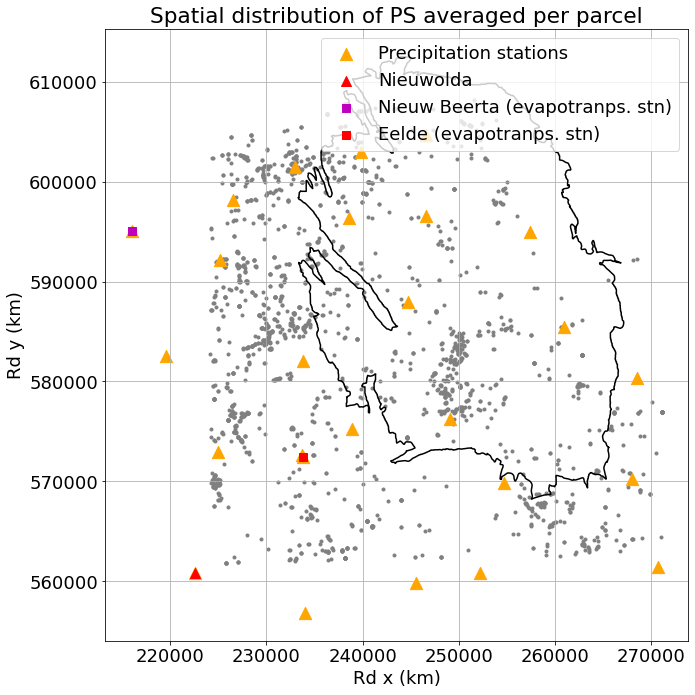

In [16]:
### Import data to assimilate
data_frame = pd.read_csv('InSAR/insart88_assimilationpnt_parcel2015_2020_Ny288.csv')

dates = np.loadtxt('InSAR/insar_dates_t88.txt')

## Plot the location of the observations --> to improve later
plt.figure(figsize=(10,10))
plt.scatter(df_reduce['Rdx'], df_reduce['Rdy'], marker='.', c='grey')
plt.scatter(df_station['Rdx'], df_station['Rdy'], marker='^', c='orange', s=150, label='Precipitation stations')
plt.scatter(df_nw['Rdx'], df_nw['Rdy'], marker='^', c='red', s=100, label='Nieuwolda')

plt.scatter(df_nb['Rdx'], df_nb['Rdy'], marker='s', c='m', s=50, label='Nieuw Beerta (evapotranps. stn)')
plt.scatter(df_eelde['Rdx'], df_eelde['Rdy'], marker='s', c='red', s=50, label='Eelde (evapotranps. stn)')

plt.plot(x_field, y_field, 'k')
plt.xlabel('Rd x (km)')
plt.ylabel('Rd y (km)')
plt.title('Spatial distribution of PS averaged per parcel')
plt.legend(loc="upper right")
plt.tight_layout()
plt.grid(True)

xaxis = [0, 18, 50, 106, 159, 218]
# year-month-day
xlabel = ['2015-05-03',
          '2016-01-10',
          '2017-01-04',
          '2018-01-05',
          '2019-01-06',
          '2020-01-01']



## Create gridding of 2 per 2 km

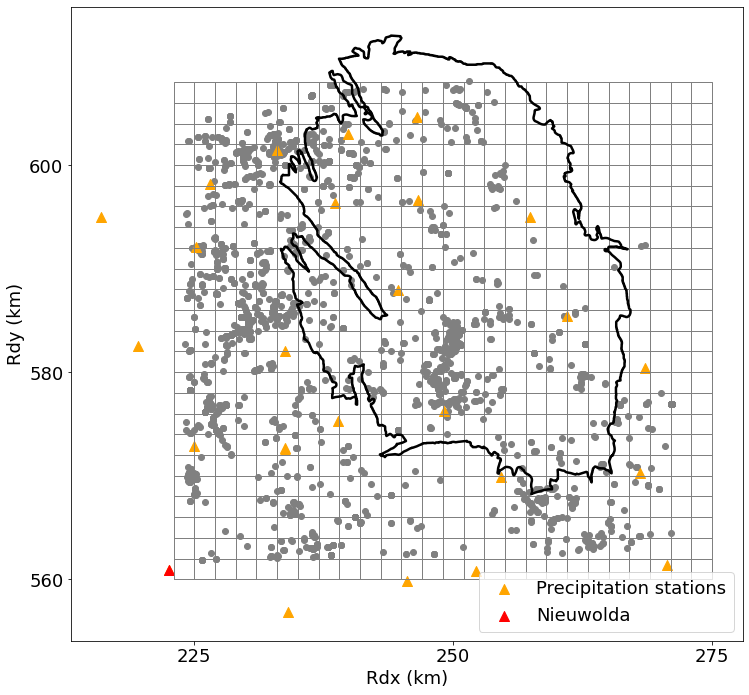

In [17]:
### Gridding points
# Create geopandas dataframe from the insar dataframe
geo_insar = gpd.GeoDataFrame(df_reduce, geometry=gpd.points_from_xy(df_reduce.Rdx, df_reduce.Rdy))
# area
xmin, xmax = 225000, 275000 # meters
ymin, ymax = 560000, 605000
cell_size = 2 * 1e3 # 2 km

# Create the cell in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        x1 = x0 - cell_size
        y1 = y0 + cell_size
        grid_cells.append( shapely.geometry.box(x0, y0, x1, y1) )

cell = gpd.GeoDataFrame(grid_cells, columns={'geometry'} )# geometry=geopandas.points_from_xy(insar.Rdx, insar.Rdy))

### Merge the dataframe with the cells with the point scatterer ###
pnt_in_cells = geo_insar.sjoin(cell, how='left', predicate='within')

### display de grid ###
xlabel = ['225', '250', '275']
ylabel = ['560', '580', '600']
fig, ax = plt.subplots(figsize=(12,10))
plt.scatter(geo_insar.Rdx, geo_insar.Rdy, c='grey')#geo_insar.iloc[:,4], cmap='jet_r', vmin=-10e-3, vmax=10e-3)
plt.scatter(df_station['Rdx'], df_station['Rdy'], marker='^', c='orange', s=100, label='Precipitation stations')
plt.scatter(df_nw['Rdx'], df_nw['Rdy'], marker='^', c='red', s=100, label='Nieuwolda')
cell.plot(ax=ax, facecolor="none", edgecolor='grey')
plt.plot(x_field, y_field, 'k', linewidth=2.5)
plt.legend()

plt.xticks([225e3, 250e3, 275e3], xlabel)
plt.yticks([560e3, 580e3, 600e3], ylabel)
plt.xlabel('Rdx (km)')
plt.ylabel('Rdy (km)')

plt.tight_layout()


### Select the points closed to Nieuwolda

In [19]:
# Coordinates of the station
df_station.Rdx.iloc[nw_ID]
point = Point(df_station.Rdx.iloc[nw_ID], df_station.Rdy.iloc[nw_ID])

# Find the grid cell that contains the station
cell_nb = cell.contains(point, align=True)
cell_nb = cell_nb[cell_nb==True]
print('grid cell ID', cell_nb)

## Test the number of points in this grdi cell
pnt_test = pnt_in_cells[pnt_in_cells.index_right == 444]

print('Number of obs points in this grid cell:', len(pnt_test))

grid cell ID Series([], dtype: bool)
Number of obs points in this grid cell: 2


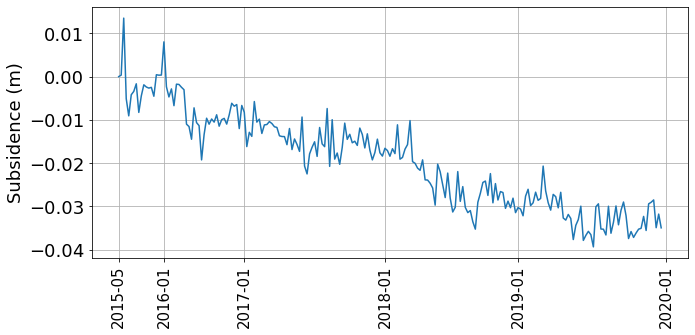

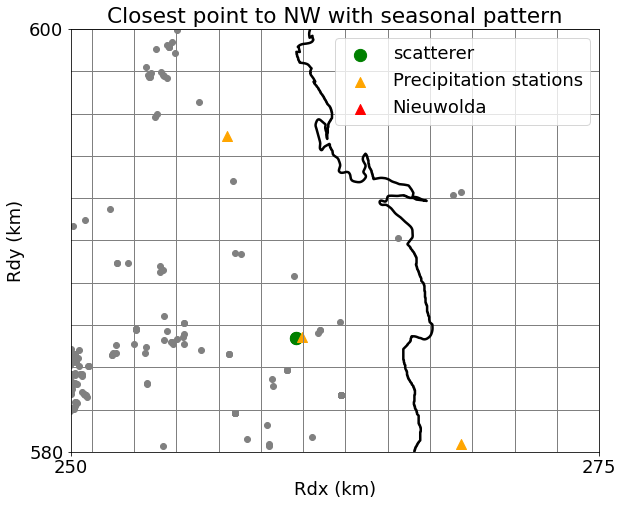

In [21]:
### Plot the time series of the points closed to Nieuwolda

xaxis = [0, 18, 50, 106, 159, 218]
# year-month-day
xlabel = ['2015-05',
          '2016-01',
          '2017-01',
          '2018-01',
          '2019-01',
          '2020-01']
plt.figure(figsize=(10,5), facecolor='w')#, dpi=150)
plt.plot(pnt_test.iloc[0,3:3+217],'-')
plt.xticks(xaxis, labels=xlabel, rotation='vertical',fontsize=15)
plt.ylabel('Subsidence (m)')
plt.tight_layout()
plt.grid(True)
#plt.savefig('NW_InSAR.png')

### display de grid ###
xlabel = ['250', '275']
ylabel = ['580', '600']
fig, ax = plt.subplots(figsize=(9,8), facecolor='w')#, dpi=150)
plt.scatter(geo_insar.Rdx, geo_insar.Rdy, c='grey')
plt.scatter(pnt_test.Rdx, pnt_test.Rdy, c='g', s=150, label='scatterer')

plt.scatter(df_station['Rdx'], df_station['Rdy'], marker='^', c='orange', s=100, label='Precipitation stations')
plt.scatter(df_nw['Rdx'], df_nw['Rdy'], marker='^', c='red', s=100, label='Nieuwolda')
cell.plot(ax=ax, facecolor="none", edgecolor='grey')
plt.plot(x_field, y_field, 'k', linewidth=2.5)
plt.legend()
plt.xlim([250e3, 275e3])
plt.ylim([580e3, 600e3])
plt.xticks([250e3, 275e3], xlabel)
plt.yticks([580e3, 600e3], ylabel)
plt.xlabel('Rdx (km)')
plt.ylabel('Rdy (km)')
plt.title('Closest point to NW with seasonal pattern')
plt.tight_layout()

#plt.savefig('NWstations_map.png')

# Apply SPAMS for the reversible component to the timeseries close to NW

For a first test I remove the trend which comes from the deep (this will be done in the DA)

In [23]:
# time serie displacement: point in cell 444
df_dispNW = pnt_test.iloc[0,:]


In [24]:
# detrended signal 
# interpolation
y_regr = np.zeros(len(x_year))

# equivalent to the displacement velocity
slope, intercept, r, p, std_err = stats.linregress(x_year, df_dispNW.iloc[3:3+217].to_numpy(float32))        
y_regr = slope * x_year + intercept

df_detrNW = df_dispNW.iloc[3:3+217] - y_regr

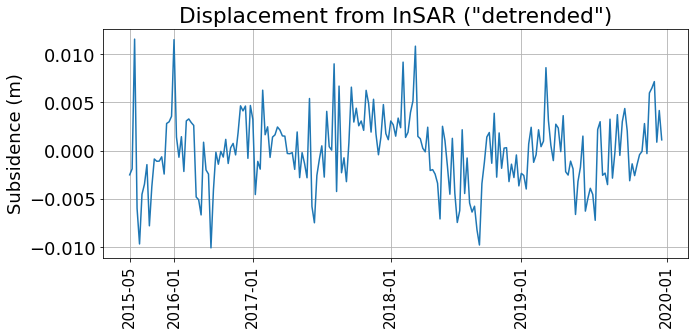

In [25]:
# Plot of the detrended displacement time serie
xaxis = [0, 18, 50, 106, 159, 218]
# year-month-day
xlabel = ['2015-05',
          '2016-01',
          '2017-01',
          '2018-01',
          '2019-01',
          '2020-01']
plt.figure(figsize=(10,5), facecolor='w')#, dpi=150)
plt.plot(df_detrNW ,'-')
plt.xticks(xaxis, labels=xlabel, rotation='vertical',fontsize=15)
plt.ylabel('Subsidence (m)')
plt.title('Displacement from InSAR ("detrended")')
plt.tight_layout()
plt.grid(True)
#plt.savefig('NW_InSARdetr.png')

20150505
20191231
05/05/2015
12/31/2019


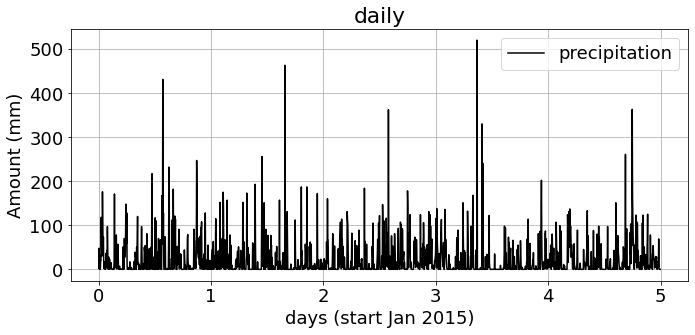

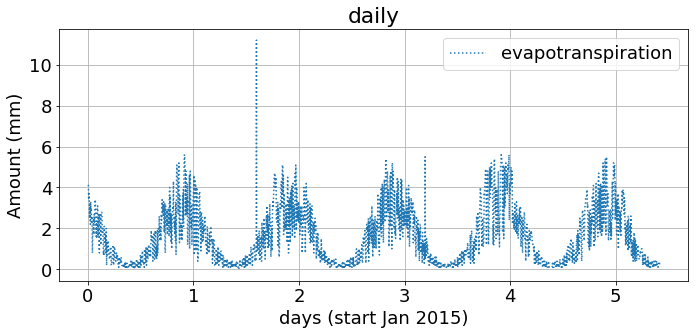

In [26]:
# import daily precipitation for NW
df_NW = pd.read_csv('KNMI_data20152020/neerslaggeg_NIEUWOLDA_172.csv')
print(df_NW.iloc[8404,1])
print(df_NW.iloc[10105,1])
df_NW_ts= df_NW.iloc[8280:10105,2].to_numpy()

# import daily evapotranspiration for NW: station Nieuw Beerta
df_NB = pd.read_csv('KNMI_data20152020/NBeerta_evapotransp20152020.csv')
print(df_NB.iloc[277,1])
print(df_NB.iloc[1978,1])
df_NB_ts= df_NB.iloc[0:1978,2].to_numpy()


axis = np.arange(0,len(df_NW_ts))
axis = axis/365
plt.figure(figsize=(10,5))
plt.plot(axis, df_NW_ts,'-',c='black', label='precipitation')
#plt.plot(axis, df_NB_ts,':', label='evapotranspiration')
#plt.xticks(xaxis, labels=xlabel, rotation='vertical',fontsize=15)
plt.ylabel('Amount (mm)')
plt.xlabel('days (start Jan 2015)')
plt.title('daily')
plt.legend()
plt.tight_layout()
plt.grid(True)

plt.figure(figsize=(10,5))
plt.plot(np.arange(0,len(df_NB_ts))/365, df_NB_ts,':', label='evapotranspiration')
#plt.xticks(xaxis, labels=xlabel, rotation='vertical',fontsize=15)
plt.ylabel('Amount (mm)')
plt.xlabel('days (start Jan 2015)')
plt.title('daily')
plt.legend()
plt.tight_layout()
plt.grid(True)

# import the daily measurement of evpotranspiration (see where to find this...)

### We can start playing with the model by testing some values:

In [27]:
# test some values
xp, xe = 2e-3,20e-3 # in [m/m]
xi = -1e-5 # in [m/d]
#tau = 2 # 1 months
tau = 90 # days

### Reload the precipitation and evapotranspiration given tau
# start 5rst of May 2015, and 31 Dec 2019
start_p, end_p = 8404, 10105 
start_e, end_e = 277, 1978 
# load the date with a period tau in front for the first date of integration
df_NW_ts= df_NW.iloc[start_p-tau:end_p,2].to_numpy()
df_NB_ts= df_NB.iloc[start_e-tau:end_e,2].to_numpy()

# nepoch depends on the InSAR time serie: Jan2015 to end Dec 2019
#nepoch = len(df_NW_ts) - tau
ndays = end_p - start_p
rev_array = np.zeros(ndays)
irr_array = np.zeros(ndays)
x_array = np.zeros(ndays)
k=tau
for t in range(ndays): # time index to compute the model
    rev = 0
    irr = 0
    for i in range(tau): # integration over the period tau, we need a step back of tau for the integration
        # For detail: 
        # First step, k=tau, so we start at index 0 and increment i from -tau until e.g., tau=90. We get the first value for 01 jan 2015
        # Second stat, k=tau+1, so we increment of 1 day (to get a value in 02 Jan 2015), increment i from -tau to tau=90 etc
        rev = rev + (xp*df_NW_ts[k+i-tau] - xe *df_NB_ts[k+i-tau])*1e-3 # conversion in meter
        
    rev_array[t] = rev
    
    # Compute the irreversible component
    if rev > 0:
        irr_array[t] = 0
    if rev <= 0:
        irr_array[t] = 1
    
    k+=1
    x_array[t] = k-tau

irr_comp = -0.1e-5 * np.cumsum(irr_array)    


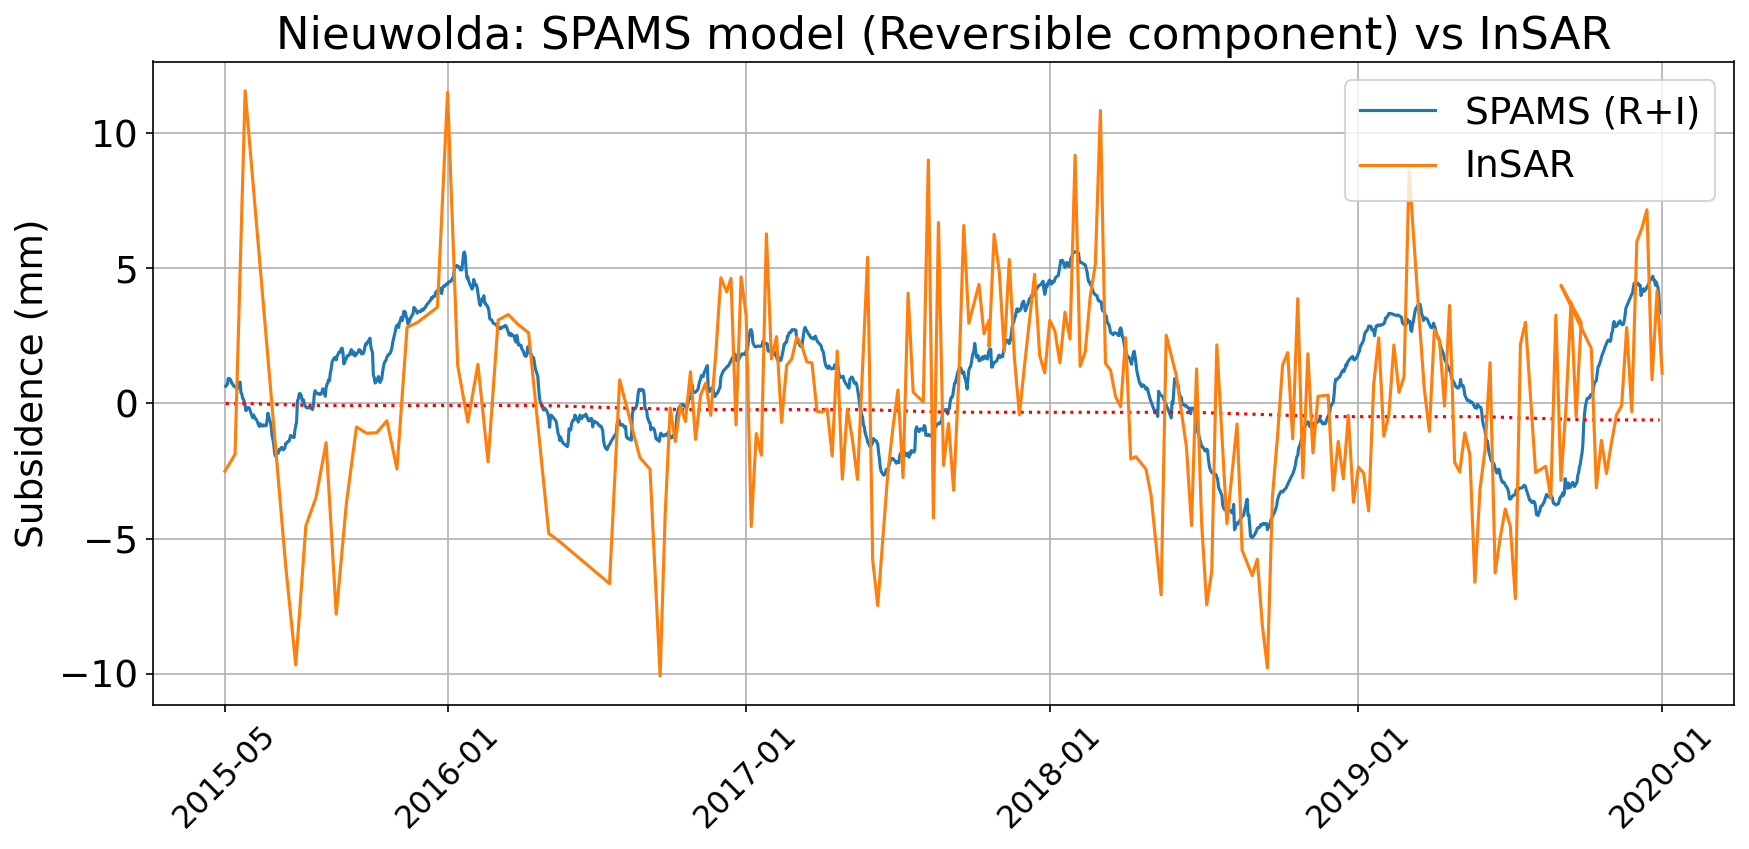

In [28]:
# Visualize the model
#xaxis = [0, 18, 50, 106, 159, 218]
# year-month-day
#xlabel = ['2015-05','2016-01','2017-01','2018-01','2019-01','2020-01']
xaxis = [0, 12, 25, 37, 48, 60]
xaxis_insar = [dates[0], dates[18], dates[50], dates[106], dates[159], dates[216]]
# year-month-day
xlabel = ['2015-05',
          '2016-01',
          '2017-01',
          '2018-01',
          '2019-01',
          '2020-01']

plt.figure(figsize=(12,6), facecolor='w', dpi=150)
plt.plot(x_array, rev_array*1e3 + irr_comp*1e3,'-', label='SPAMS (R+I)') # mm/day
plt.plot(x_array, irr_comp*1e3,'r:') ## m/day
plt.plot(dates,df_detrNW*1e3 ,'-', label='InSAR') # in the dataframe we have negative values for subsidence
plt.xticks(xaxis_insar, labels=xlabel, rotation='45',fontsize=15)
plt.ylabel('Subsidence (mm)')
plt.title('Nieuwolda: SPAMS model (Reversible component) vs InSAR')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.savefig('outputfig/NW_SPAMS_InSARdetr_test.png')

## Optimization with DA

State vector to estime $x=[x_p, x_e, x_i]$

In [29]:
## Observations: displacement estimates (detrended)
### Starting date in the InSAR time serie 20150503 (3rd march 2015)
y_da = df_detrNW.to_numpy(float32) # 217 epochs

In [30]:
# Define the prior for the model parameters
Ne = 500 # ensemble size
tau = np.arange(50,91)

x_para = np.zeros((Ne,3)) 
val_min, val_max = 1e-3, 5e-3
xp = np.random.uniform(low=val_min, high=val_max, size=Ne) # uniform distribution because there is no physics behind

val_min, val_max = 5e-3, 20e-3
xe = np.random.uniform(low=val_min, high=val_max, size=Ne)

val_min, val_max = -0.1e-5, -1e-3
xi = np.random.uniform(low=val_min, high=val_max, size=Ne)

x_para[:,0], x_para[:,1], x_para[:,2] = xp, xe, xi


In [31]:
# We use a standard PF
x_p = np.zeros(Ne)
sigma_lik = 1e-3

# time window for the integration of the precipitation and the evaporation
tau[0]=80

### Reload the precipitation and evapotranspiration given tau
start_p, end_p = 8404, 10105
start_e, end_e = 277, 1978

model_days = end_p - start_p
# load the date with a period tau in front for the first date of integration
df_NW_ts= df_NW.iloc[start_p-tau[0]:end_p,2].to_numpy()
df_NB_ts= df_NB.iloc[start_e-tau[0]:end_e,2].to_numpy()

Ny=1
for simu in range(1):
    # Weight and # Likelihoods array
    p_w = np.ones(Ne, dtype=np.float64)
    dlpsi = np.zeros((Ne, len(dates)), dtype=np.float64)
    likelihood_ts = np.zeros(Ne, dtype=np.float64)

    rev_array = np.zeros((Ne,model_days))
    irr_array = np.zeros(ndays)
    irr_comp = np.zeros((Ne,ndays))
    x_array = np.zeros(model_days)
    
    for m in range(Ne):
        k=tau[0]
        for t in range(model_days): # time index to compute the model
            rev = 0
            irr = 0
            for i in range(tau[0]): # integration over the period tau, we need a step back of tau for the integration
                rev = rev + (xp[m]*df_NW_ts[k+i-tau[0]] - xe[m]*df_NB_ts[k+i-tau[0]])*1e-3 # conversion in meter
        
            rev_array[m,t] = rev
            
            # Compute the irreversible component
            if rev > 0:
                irr_array[t] = 0
            if rev <= 0:
                irr_array[t] = 1
            
            k+=1
            x_array[t] = k-tau[0]
        irr_comp[m,:] = xi[m] * np.cumsum(irr_array)
        
    ## Calculation of the difference data/model
    # Difference data and model prediction at time k
    # 1- select the model at the correct dates of the data: array dates
    model_t = np.zeros((Ne, len(dates)))   
    for i in range(len(dates)-1):
        nday_insar = int(dates[i]) # number of days of the InSAR epoch
        # From the previous step: rev_array start at t=0 the beginning of the InSAR time serie on te 5th May 2015
        # And the model rev_array is computed every day
        model_t[:,i] = rev_array[:,nday_insar] + irr_comp[:,nday_insar]
    
    # 2- compute the likelihood
    for i in range(Ne):
        likelihood_ts[i] = np.square(np.subtract(y_da, model_t[i,:])).mean()
        likelihood_ts[i] = (1/sqrt(2*pi*sigma_lik**2))*np.exp(-0.5*likelihood_ts[i]/(sigma_lik**2))

    # Calculation of the weights
    for i in range(Ne):
        for j in range(len(y_da)): # so there we have the number of time step instead of the location of observation, equivalent?
            p_w[i] = p_w[i] * likelihood_ts[i]
            #print(p_w[i])

    # Normalization
    p_w = p_w / np.sum(p_w)
    
    ###############################
    # Analysis for the simulation #
    ###############################
    ## Weighted mean for the estimation of the compaction coefficient
    estimate_xe = np.sum(np.multiply(xe, p_w.T))
    estimate_xp = np.sum(np.multiply(xp, p_w.T))
    estimate_xi = np.sum(np.multiply(xi, p_w.T))
    
    print('Estimate xp [m/m]', estimate_xp)
    print('Estimate xe [m/m]', estimate_xe)
    print('Estimate xi [m/d]', estimate_xi)
    
    ###############################################
    ## Recompute the model with the best estimate
    ndays = end_p - start_p
    rev_est = np.zeros(ndays)
    irr_est = np.zeros(ndays)
    x_array = np.zeros(ndays)
    k=tau[0]
    for t in range(ndays): # time index to compute the model
        rev = 0
        for i in range(tau[0]): # integration over the period tau, we need a step back of tau for the integration
            rev = rev + (estimate_xp*df_NW_ts[k+i-tau[0]] - estimate_xe *df_NB_ts[k+i-tau[0]])*1e-3 # conversion in meter
        
        rev_est[t] = rev
        
        # Compute the irreversible component
        if rev > 0:
            irr_array[t] = 0
        if rev <= 0:
            irr_array[t] = 1
        
        k+=1
        x_array[t] = k-tau[0]

    irr_est = estimate_xi * np.cumsum(irr_array)

    ## To compute the RMSE
    # Select the model at the correct dates of the data: array dates
    model_estimate = np.zeros(len(dates))
    for i in range(len(dates)-1):
        nday_insar = int(dates[i]) # number of days of the InSAR epoch
        # From the previous step: rev_array start at t=0 the beginning of the InSAR time serie on te 5th May 2015
        # And the model rev_array is computed every day
        model_estimate[i] = rev_est[nday_insar] + irr_est[nday_insar]

    ## Compute the RMSE
    MSE = np.square(np.subtract(y_da, model_estimate)).mean() 
    RMSE = math.sqrt(MSE)
    print("Root Mean Square Error:\n", RMSE)


Estimate xp [m/m] 0.0014569979705162878
Estimate xe [m/m] 0.013300464846384027
Estimate xi [m/d] -5.2788019333734165e-06
Root Mean Square Error:
 0.003539249339266061


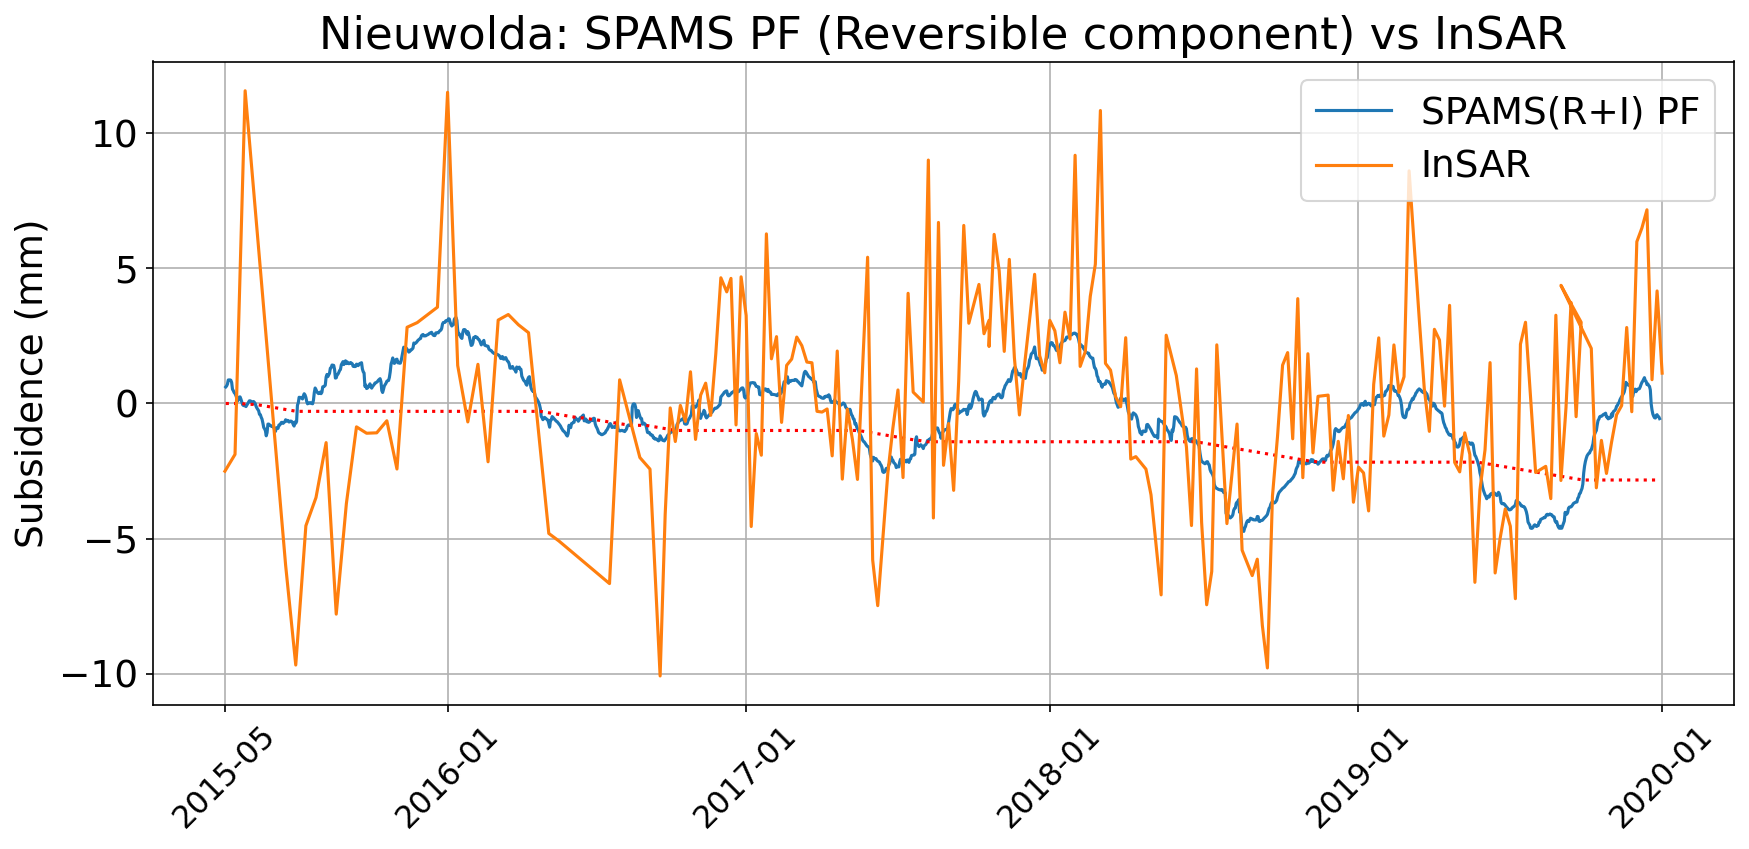

In [32]:
# Visualize PF results
xaxis = [0, 12, 25, 37, 48, 60]
xaxis_insar = [dates[0], dates[18], dates[50], dates[106], dates[159], dates[216]]
# year-month-day
xlabel = ['2015-05',
          '2016-01',
          '2017-01',
          '2018-01',
          '2019-01',
          '2020-01']

plt.figure(figsize=(12,6), facecolor='w', dpi=150)
plt.plot(x_array, rev_est*1e3 + irr_est*1e3,'-', label='SPAMS(R+I) PF') # [mm]
plt.plot(x_array, irr_est*1e3,'r:') #[mm/day]
plt.plot(dates, df_detrNW*1e3 ,'-', label='InSAR') # in the dataframe we have negative values for subsidence
plt.xticks(xaxis_insar, labels=xlabel, rotation='45',fontsize=15)
plt.ylabel('Subsidence (mm)')
plt.title('Nieuwolda: SPAMS PF (Reversible component) vs InSAR')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.savefig('outputfig/PF_NW_SPAMS_InSARdetr.png')

# Test on the two other points in the East of Nieuwolda

In [33]:
# The parcels are in the grid ID
# Coordinate of the station 468
#df_station.Rdx.iloc[nw_ID]
#point = Point(df_station.Rdx.iloc[nw_ID], df_station.Rdy.iloc[nw_ID])

# Find the grid cell that contains the station
#cell_nb = cell.contains(point, align=True)
#cell_nb = cell_nb[cell_nb==True]
#print('grid cell ID', cell_nb)

## Test the number of points in this grdi cell
pnt_test = pnt_in_cells[pnt_in_cells.index_right == 468]

print('Number of obs points in this grid cell:', len(pnt_test))
pnt1 = pnt_test.iloc[0,:]
pnt2 = pnt_test.iloc[1,:]

#print(pnt1)
#print(pnt2)

Number of obs points in this grid cell: 3


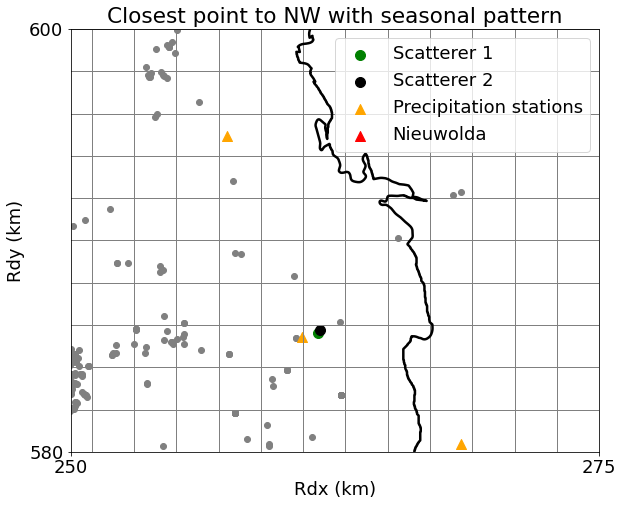

In [34]:
### display de grid ###
xlabel = ['250', '275']
ylabel = ['580', '600']
fig, ax = plt.subplots(figsize=(9,8), facecolor='w')#, dpi=150)
plt.scatter(geo_insar.Rdx, geo_insar.Rdy, c='grey')
plt.scatter(pnt1.Rdx, pnt1.Rdy, c='g', s=100, label='Scatterer 1')
plt.scatter(pnt2.Rdx, pnt2.Rdy, c='k', s=100, label='Scatterer 2')

plt.scatter(df_station['Rdx'], df_station['Rdy'], marker='^', c='orange', s=100, label='Precipitation stations')
plt.scatter(df_nw['Rdx'], df_nw['Rdy'], marker='^', c='red', s=100, label='Nieuwolda')
cell.plot(ax=ax, facecolor="none", edgecolor='grey')
plt.plot(x_field, y_field, 'k', linewidth=2.5)
plt.legend()
plt.xlim([250e3, 275e3])
plt.ylim([580e3, 600e3])
plt.xticks([250e3, 275e3], xlabel)
plt.yticks([580e3, 600e3], ylabel)
plt.xlabel('Rdx (km)')
plt.ylabel('Rdy (km)')
plt.title('Closest point to NW with seasonal pattern')
plt.tight_layout()

### Plot the time series of the two points
It stills works more or less but we can see that the input precipitation and evapotranspiration are from an other location;
- We give a code in an other repository to interpolate precipitation data P(t) over the Groningen region
- Note that result can be improves with a larger ensemble size ($N_e=100$ by default to provide fast run of the notebook)

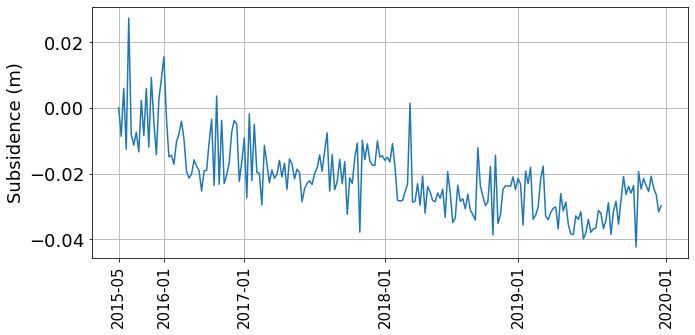

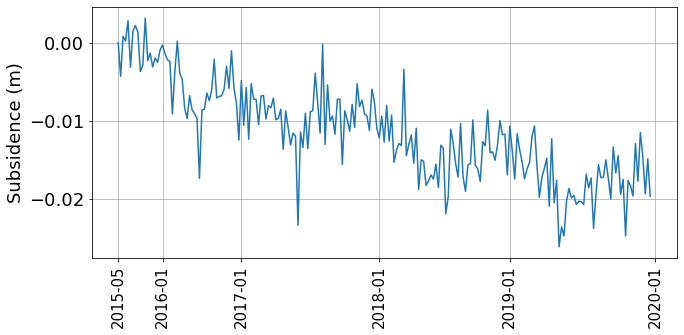

In [41]:
### Point 1
xaxis = [0, 18, 50, 106, 159, 218]
# year-month-day
xlabel = ['2015-05',
          '2016-01',
          '2017-01',
          '2018-01',
          '2019-01',
          '2020-01']
plt.figure(figsize=(10,5), facecolor='w')#, dpi=150)
plt.plot(pnt_test.iloc[0,3:3+217],'-')
plt.xticks(xaxis, labels=xlabel, rotation='vertical',fontsize=15)
plt.ylabel('Subsidence (m)')
plt.tight_layout()
plt.grid(True)
#plt.savefig('NW_InSAR.png')

### Point 2
plt.figure(figsize=(10,5), facecolor='w')#, dpi=150)
plt.plot(pnt_test.iloc[1,3:3+217],'-')
plt.xticks(xaxis, labels=xlabel, rotation='vertical',fontsize=15)
plt.ylabel('Subsidence (m)')
plt.tight_layout()
plt.grid(True)
#plt.savefig('NW_InSAR.png')

### Plot the detrended time series

In [42]:
# detrended signal 1
y_regr1, y_regr2 = np.zeros(len(x_year)), np.zeros(len(x_year))

slope1, intercept1, r, p, std_err = stats.linregress(x_year, pnt_test.iloc[0, 3:3+217].to_numpy(float32))        
y_regr1 = slope1 * x_year + intercept1

slope2, intercept2, r, p, std_err = stats.linregress(x_year, pnt_test.iloc[1, 3:3+217].to_numpy(float32))        
y_regr2 = slope2 * x_year + intercept2

pnt1_detr = pnt_test.iloc[0, 3:3+217] - y_regr1
pnt2_detr = pnt_test.iloc[1, 3:3+217] - y_regr2


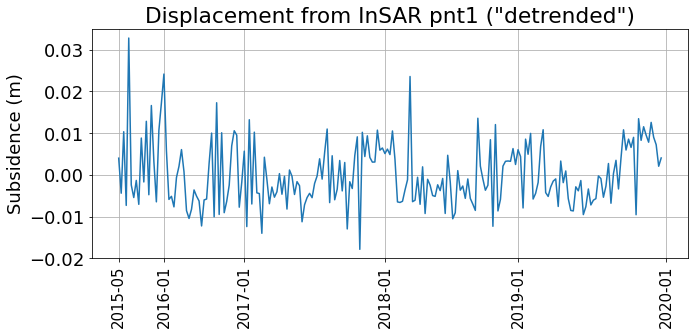

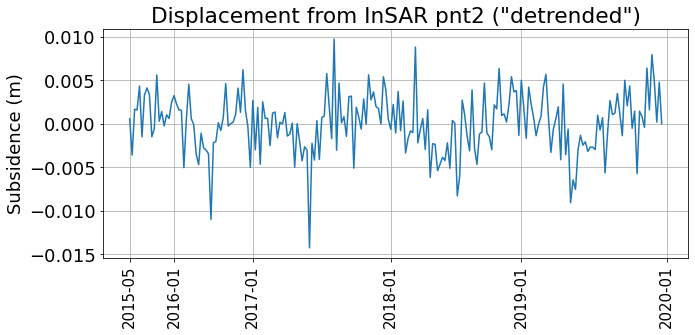

In [43]:
# Plot of the detrended displacement time serie
plt.figure(figsize=(10,5), facecolor='w')#, dpi=150)
plt.plot(pnt1_detr ,'-')
plt.xticks(xaxis, labels=xlabel, rotation='vertical',fontsize=15)
plt.ylabel('Subsidence (m)')
plt.title('Displacement from InSAR pnt1 ("detrended")')
plt.ylim([-0.02, 0.035])
plt.tight_layout()
plt.grid(True)
#plt.savefig('NW_InSARdetr.png')

plt.figure(figsize=(10,5), facecolor='w')#, dpi=150)
plt.plot(pnt2_detr ,'-')
plt.xticks(xaxis, labels=xlabel, rotation='vertical',fontsize=15)
plt.ylabel('Subsidence (m)')
plt.title('Displacement from InSAR pnt2 ("detrended")')
#plt.ylim([-0.02, 0.035])
plt.tight_layout()
plt.grid(True)

### Optmization with DA

In [44]:
## Observations: displacement estimates (detrended)
### Starting date in the InSAR time serie 20150503 (3rd march 2015)
y1 = pnt1_detr.to_numpy(float32) # 217 epochs
y2 = pnt2_detr.to_numpy(float32) # 217 epochs
y_da = y2

In [45]:
# Define the prior for the model parameters
Ne = 100 # ensemble size
tau = np.arange(50,91)

x_para = np.zeros((Ne,2)) 
val_min, val_max = 1e-3, 5e-3
xp = np.random.uniform(low=val_min, high=val_max, size=Ne) # uniform distribution because there is no physics behind

val_min, val_max = 5e-3, 20e-3
xe = np.random.uniform(low=val_min, high=val_max, size=Ne)

x_para[:,0], x_para[:,1] = xp, xe

In [46]:
# We use a standard PF because there is few observation
x_p = np.zeros(Ne)
sigma_lik = 1e-3

# time window for the integration of the precipitation and the evaporation
tau[0]=90

### Reload the precipitation and evapotranspiration given tau
start_p, end_p = 8404, 10105
start_e, end_e = 277, 1978

model_days = end_p - start_p
# load the date with a period tau in front for the first date of integration ---> unless we make an interpolation of the precipitation
df_NW_ts= df_NW.iloc[start_p-tau[0]:end_p,2].to_numpy()
df_NB_ts= df_NB.iloc[start_e-tau[0]:end_e,2].to_numpy()

Ny=1
for simu in range(1):
    # Weight and # Likelihoods array
    p_w = np.ones(Ne, dtype=np.float64)
    dlpsi = np.zeros((Ne, len(dates)), dtype=np.float64)
    likelihood_ts = np.ones(Ne, dtype=np.float64)

    rev_array = np.zeros((Ne,model_days))
    x_array = np.zeros(model_days)
    
    for m in range(Ne):
        k=tau[0]
        for t in range(model_days): # time index to compute the model
            rev = 0
            for i in range(tau[0]): # integration over the period tau, we need a step back of tau for the integration
                rev = rev + (xp[m]*df_NW_ts[k+i-tau[0]] - xe[m]*df_NB_ts[k+i-tau[0]])*1e-3 # conversion in meter
        
            rev_array[m,t] = rev
            k+=1
            x_array[t] = k-tau[0]
        
    ## Calculation of the difference data/model
    # Difference data and model prediction at time k
    # 1- select the model at the correct dates of the data: array dates
    model_t = np.zeros((Ne, len(dates)))   
    for i in range(len(dates)-1):
        nday_insar = int(dates[i]) # number of days of the InSAR epoch
        # From the previous step: rev_array start at t=0 the beginning of the InSAR time serie on te 5th May 2015
        # And the model rev_array is computed every day
        model_t[:,i] = rev_array[:,nday_insar]
    
    # 2- compute the likelihood
    #dlpsi = np.zeros((Ne, len(y_da)), dtype=np.float64)
    for i in range(Ne):
    #    for j in range(Ny): # --> we have one observation          
        #dlpsi[i,:] = (y2 - model_t[i,:])**2 # meter**2
        likelihood_ts[i] = np.square(np.subtract(y_da, model_t[i,:])).mean()
        likelihood_ts[i] = (1/sqrt(2*pi*sigma_lik**2))*np.exp(-0.5*likelihood_ts[i]/(sigma_lik**2))
            
    # Calculation of the likelihoods: gaussian distribution
    #for i in range(Ne):
        #dlpsi[i, :] = (1/sqrt(2*pi*sigma_lik**2))*np.exp(-0.5*dlpsi[i, :]/(sigma_lik**2))
        #likelihood_ts[i] = (1/sqrt(2*pi*sigma_lik**2))*np.exp(-0.5*likelihood_ts[i]/(sigma_lik**2))
        
    # Calculation of the weights
    #for i in range(Ne):
     #   for j in range(len(y_da)): # so there we have the number of time step instead of the location of observation, equivalent?
      #      p_w[i] = p_w[i] * dlpsi[i,j] *10

    for i in range(Ne):
        #for j in range(len(y_da)): # so there we have the number of time step instead of the location of observation, equivalent?
        p_w[i] = p_w[i] * likelihood_ts[i]
        #print(p_w[i])

    # Normalization
    p_w = p_w / np.sum(p_w)
    
    ###############################
    # Analysis for the simulation #
    ###############################
    ## Weighted mean for the estimation of the compaction coefficient
    #estimate = np.zeros(Nx)
    #for i in range(Nx):
    #    estimate[i] = np.sum(np.multiply(x_p, p_w.T))
    estimate_xe = np.sum(np.multiply(xe, p_w.T))
    estimate_xp = np.sum(np.multiply(xp, p_w.T))
    
    print('Estimate xp', estimate_xp)
    print('Estimate xe', estimate_xe)
    
    ###############################################
    ## Recompute the model with the best estimate
    ndays = end_p - start_p
    rev_est = np.zeros(ndays)
    x_array = np.zeros(ndays)
    k=tau[0]
    for t in range(ndays): # time index to compute the model
        rev = 0
        for i in range(tau[0]): # integration over the period tau, we need a step back of tau for the integration
            rev = rev + (estimate_xp*df_NW_ts[k+i-tau[0]] - estimate_xe *df_NB_ts[k+i-tau[0]])*1e-3 # conversion in meter
        
        rev_est[t] = rev
        k+=1
        x_array[t] = k-tau[0]

    ## To compute the RMSE
    # 1- select the model at the correct dates of the data: array dates
    model_estimate = np.zeros(len(dates))
    for i in range(len(dates)-1):
        nday_insar = int(dates[i]) # number of days of the InSAR epoch
        # From the previous step: rev_array start at t=0 the beginning of the InSAR time serie on te 5th May 2015
        # And the model rev_array is computed every day
        model_estimate[i] = rev_est[nday_insar]

    ## Compute the RMSE
    MSE = np.square(np.subtract(y_da, model_estimate)).mean() 
    RMSE = math.sqrt(MSE)
    print("Root Mean Square Error:\n", RMSE)


Estimate xp 0.001470779391374483
Estimate xe 0.014164648820751812
Root Mean Square Error:
 0.0035690679716998595


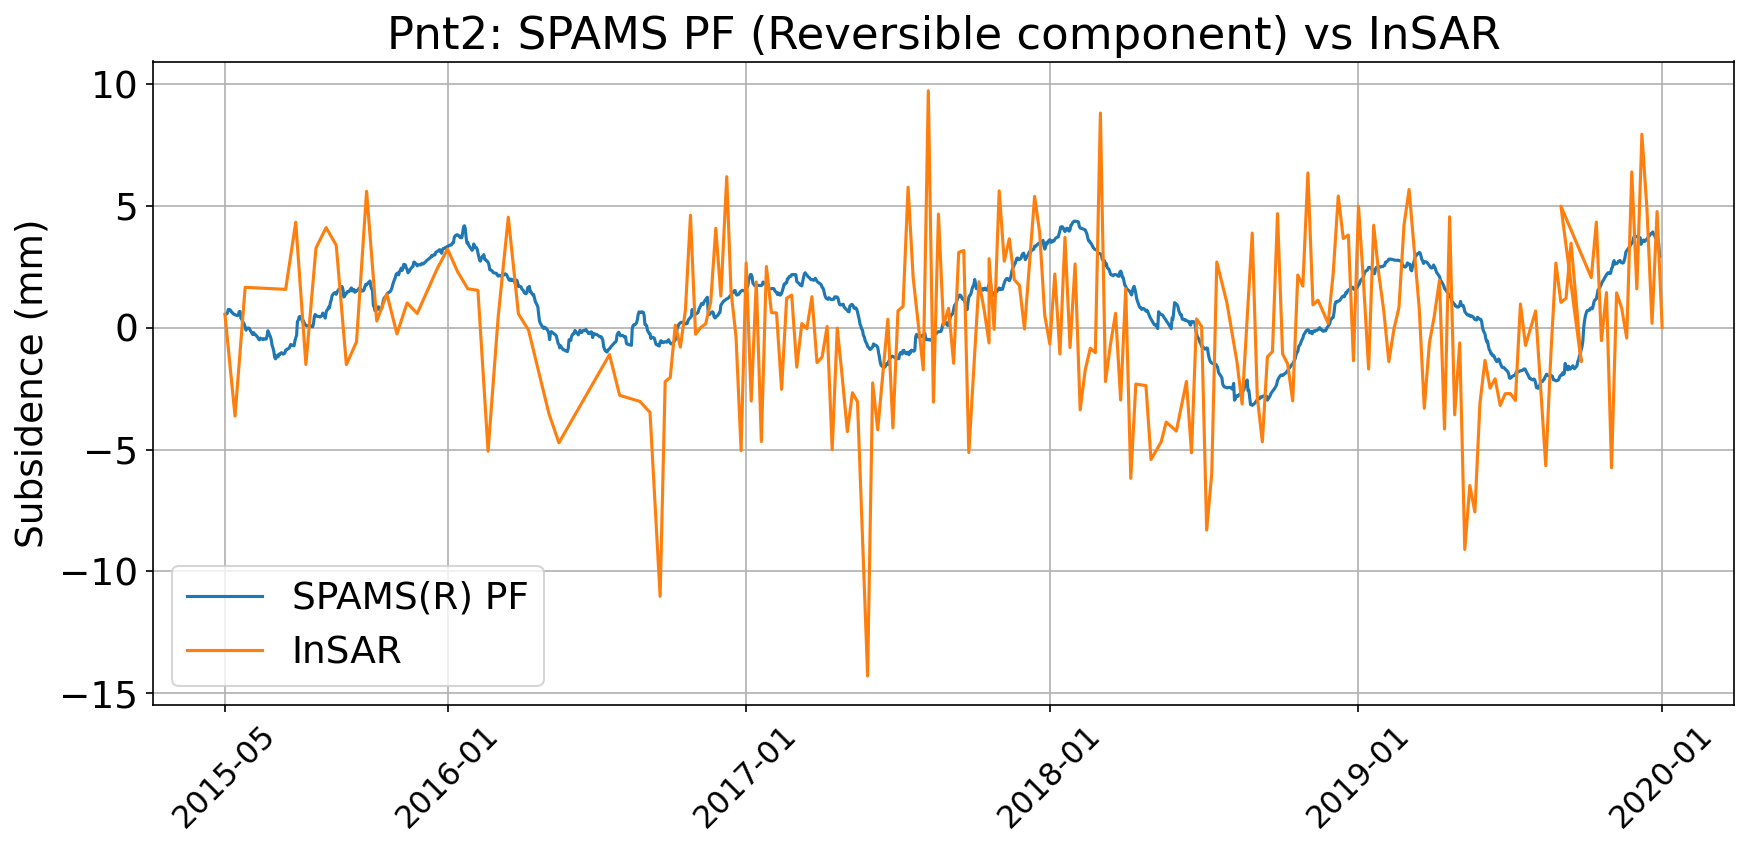

In [47]:
# Visualize PF results for point1
xaxis = [0, 12, 25, 37, 48, 60]
xaxis_insar = [dates[0], dates[18], dates[50], dates[106], dates[159], dates[216]]
# year-month-day
xlabel = ['2015-05',
          '2016-01',
          '2017-01',
          '2018-01',
          '2019-01',
          '2020-01']

plt.figure(figsize=(12,6), facecolor='w', dpi=150)
plt.plot(x_array, rev_est*1e3,'-', label='SPAMS(R) PF')
plt.plot(dates, pnt2_detr*1e3 ,'-', label='InSAR') # in the dataframe we have negative values for subsidence
plt.xticks(xaxis_insar, labels=xlabel, rotation='45',fontsize=15)
plt.ylabel('Subsidence (mm)')
plt.title('Pnt2: SPAMS PF (Reversible component) vs InSAR')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.savefig('outputfig/pnt2_comparisonSPAMS_InSARdetr_PF.png')